# 3-way cross-task geometry: ODR 1.5s, ODR 3.0s, ODRd

Compare Procrustes geometry across all three tasks using only the
**4 overlapping cardinal directions** (0/90/180/270) and a
**common delay window** (500–1700 ms) that precedes the ODRd distractor.

- ODR columns `[0, 2, 4, 6]` = ODRd columns `[0, 1, 2, 3]`
- Common epochs: cue (0–500 ms), delay (500–1700 ms)
- Features per neuron: 4 directions × 2 epochs = 8
- Common monkeys: OLI, PIC, ROS, UNI
- ODRd data: raw 4-column (pools all distractor variants as trials)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, sys

sys.path.insert(0, '.')
from functions import (
    load_all_task_data, load_odrd_data, extract_metadata,
    compute_flat_tuning, cross_task_cv, plot_cross_task,
)

DATA_DIR      = '../data_raw'
N_PCS         = 8
MIN_NEURONS   = N_PCS + 1
BIN_MS        = 50
COMMON_EPOCHS = {'cue': (0, 500), 'delay': (500, 1700)}
CARDINAL_COLS = [0, 2, 4, 6]   # ODR indices for 0/90/180/270
N_ITER        = 100
SEED          = 42

## 1. Load data & filter to common monkeys

In [2]:
# ODR 1.5s / 3.0s via the standard loader
task_data = load_all_task_data(DATA_DIR)

# ODRd: load raw 4-column data (before split_odrd_by_distractor)
odrd_raw, ws_odrd = load_odrd_data(
    os.path.join(DATA_DIR, 'odrd_data_sig_on_best_20231018.mat'))
odrd_ids, odrd_age, odrd_mat, _ = extract_metadata(ws_odrd, odrd_raw.shape[0])

# Common monkeys across all 3 tasks
common_monkeys = sorted(
    set(task_data['ODR 1.5s']['ids'])
    & set(task_data['ODR 3.0s']['ids'])
    & set(odrd_ids)
)
print(f'Common monkeys: {common_monkeys}')

# Filter each task to common monkeys and select cardinal columns for ODR
tasks = {}
for name in ['ODR 1.5s', 'ODR 3.0s']:
    mask = np.isin(task_data[name]['ids'], common_monkeys)
    tasks[name] = dict(
        data=task_data[name]['data'][mask][:, CARDINAL_COLS],
        ids=task_data[name]['ids'][mask],
    )
    print(f'{name}: {mask.sum()} neurons, {tasks[name]["data"].shape[1]} cardinal dirs')

# ODRd raw already has 4 columns
odrd_mask = np.isin(odrd_ids, common_monkeys)
tasks['ODRd'] = dict(
    data=odrd_raw[odrd_mask],
    ids=odrd_ids[odrd_mask],
)
print(f'ODRd: {odrd_mask.sum()} neurons, {tasks["ODRd"]["data"].shape[1]} dirs')

print('\nNeurons per monkey:')
for mid in common_monkeys:
    counts = {t: np.sum(tasks[t]['ids'] == mid) for t in tasks}
    print(f'  {mid}: ' + ', '.join(f'{t}={c}' for t, c in counts.items()))

Common monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]
ODR 1.5s: 391 neurons, 4 cardinal dirs
ODR 3.0s: 922 neurons, 4 cardinal dirs
ODRd: 1319 neurons, 4 dirs

Neurons per monkey:
  OLI: ODR 1.5s=86, ODR 3.0s=200, ODRd=292
  PIC: ODR 1.5s=77, ODR 3.0s=187, ODRd=264
  ROS: ODR 1.5s=69, ODR 3.0s=167, ODRd=236
  UNI: ODR 1.5s=159, ODR 3.0s=368, ODRd=527


## 2. Tuning curves (cue + common delay)

In [3]:
task_configs = {
    'ODR 1.5s': dict(data=tasks['ODR 1.5s']['data'], t_range=(-1000, 2500)),
    'ODR 3.0s': dict(data=tasks['ODR 3.0s']['data'], t_range=(-1000, 3500)),
    'ODRd':     dict(data=tasks['ODRd']['data'],      t_range=(-1000, 3500)),
}

tuning_flat = {}
for name, cfg in task_configs.items():
    flat, _, _ = compute_flat_tuning(cfg['data'], cfg['t_range'], COMMON_EPOCHS, BIN_MS)
    tuning_flat[name] = flat
    print(f'{name}: {flat.shape} (neurons x features)')

  neuron 0/391
ODR 1.5s: (391, 8) (neurons x features)
  neuron 0/922
  neuron 500/922
ODR 3.0s: (922, 8) (neurons x features)
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
ODRd: (1319, 8) (neurons x features)


## 3. Split-half cross-validation

In [4]:
task_ids = {name: tasks[name]['ids'] for name in tasks}
results = cross_task_cv(tuning_flat, task_ids, N_PCS, MIN_NEURONS, N_ITER, SEED)

  iteration 25/100
  iteration 50/100
  iteration 75/100
  iteration 100/100
Done.


## 4. Results and distance matrix

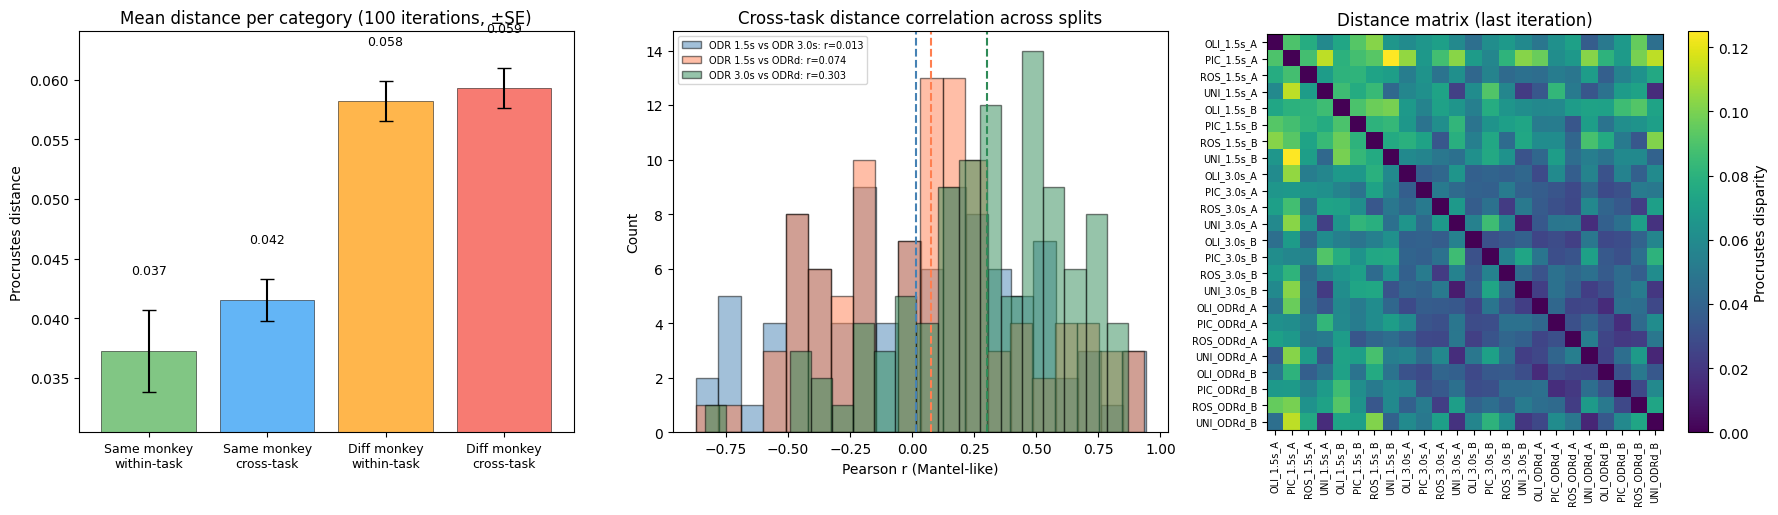

Category means [±SE]:
  Same monkey within-task         0.0373 ± 0.0034
  Same monkey cross-task          0.0416 ± 0.0017
  Diff monkey within-task         0.0582 ± 0.0017
  Diff monkey cross-task          0.0593 ± 0.0017

Mantel r:
  ODR 1.5s vs ODR 3.0s: mean = 0.013 ± 0.437 (SE)
  ODR 1.5s vs ODRd: mean = 0.074 ± 0.396 (SE)
  ODR 3.0s vs ODRd: mean = 0.303 ± 0.337 (SE)

Same monkey cross-task vs diff monkey within-task:
  diff median = -0.0166, 95% CI = [-0.0169, -0.0163], excludes zero
Same monkey cross-task vs diff monkey cross-task:
  diff median = -0.0177, 95% CI = [-0.0180, -0.0174], excludes zero


In [5]:
plot_cross_task(results)